In [ ]:
!pip install librosa
#librosa.org

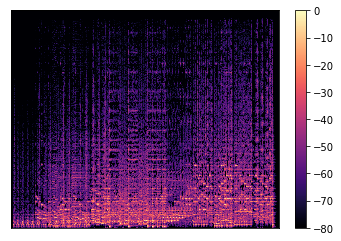

In [9]:
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt

filename = librosa.example('nutcracker')

y, sr = librosa.load(filename)

tempo, beat_frame = librosa.beat.beat_track(y=y, sr=sr)

D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()
